# Deep Markov Model (DMM) - Complete Pipeline

This notebook demonstrates the full Deep Markov Model pipeline for probabilistic time series modeling:

1. **Setup & Configuration** - Import libraries and configure model parameters
2. **Data Loading & Preprocessing** - Load and prepare time series data
3. **Model Training** - Train the DMM using variational inference
4. **Forecasting** - Generate probabilistic forecasts with uncertainty quantification
5. **Hidden Dynamics Analysis** - Interpret the learned latent representations

## 1. Setup & Configuration

In [1]:
# Standard library imports
import os
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import numpy as np
import pandas as pd
import torch
import pyro

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# DMM package imports
from dmm import (
    # Configuration
    ModelConfig,
    TrainingConfig,
    DataConfig,
    # Model
    DMMFactory,
    DeepMarkovModel,
    # Training
    DMMTrainer,
    # Inference
    DMMForecaster,
    # Analysis
    DMMInterpreter,
    # Data utilities
    preprocess_dataframe,
    build_sequences,
    sequences_to_tensors,
    train_test_split_sequences,
    # Visualization
    plot_training_loss,
    plot_forecast,
)

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Clear Pyro's parameter store for fresh start
pyro.clear_param_store()

print(f"PyTorch version: {torch.__version__}")
print(f"Pyro version: {pyro.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

PyTorch version: 2.10.0
Pyro version: 1.9.1
Device: cpu


In [2]:
# ============================================================
# CONFIGURATION
# ============================================================
# Set QUICK_TEST = True for fast iteration (fewer epochs)
# Set QUICK_TEST = False for full training

QUICK_TEST = True  # Change to False for full training

# Model architecture configuration
model_config = ModelConfig(
    z_dim=16,           # Latent state dimension
    transition_dim=64,  # Transition network hidden size
    emission_dim=32,    # Emission network hidden size
    rnn_dim=64,         # RNN hidden size for guide
    output_dim=5,       # Number of observed variables (PM10, temp, humidity, rain, wind)
)

# Training configuration
training_config = TrainingConfig(
    lr=1e-3,
    num_epochs=50 if QUICK_TEST else 500,
    print_every=10 if QUICK_TEST else 50,
    random_seed=42,
)

# Data configuration
data_config = DataConfig(
    max_nan_gap=2,      # Maximum consecutive NaN gap to interpolate
    test_size=0.2,      # Test set fraction
    columns=("PM10", "temp", "humidity", "rain", "wind"),
)

print("Configuration:")
print(f"  Quick test mode: {QUICK_TEST}")
print(f"  Latent dimension: {model_config.z_dim}")
print(f"  Training epochs: {training_config.num_epochs}")
print(f"  Features: {data_config.columns}")

Configuration:
  Quick test mode: True
  Latent dimension: 16
  Training epochs: 50
  Features: ('PM10', 'temp', 'humidity', 'rain', 'wind')


## 2. Data Loading & Preprocessing

In [3]:
def load_and_preprocess_data(filepath: str, data_config: DataConfig):
    """Load and preprocess the dataset from CSV.
    
    Args:
        filepath: Path to the CSV file.
        data_config: Data configuration.
        
    Returns:
        Tuple of (preprocessed DataFrame, normalization stats).
    """
    # Load CSV file
    df = pd.read_csv(filepath)
    
    # Convert datetime - handle mixed formats
    df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, format="mixed")
    
    # Sort by datetime
    df = df.sort_values("datetime").reset_index(drop=True)
    
    # Convert numeric columns (handle European decimal separator)
    for col in data_config.columns:
        if col in df.columns:
            # Convert to string and replace comma with dot for decimal
            df[col] = df[col].astype(str).str.replace(",", ".", regex=False)
            # Handle missing value indicators
            df[col] = df[col].replace(["N/D", "-", "nan", "None"], np.nan)
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # Extract only the columns we need
    df_subset = df[["datetime"] + list(data_config.columns)].copy()
    
    # Preprocess (normalize and fill short NaN gaps)
    df_processed, norm_stats = preprocess_dataframe(
        df_subset[list(data_config.columns)],
        data_config.columns,
        data_config.max_nan_gap,
    )
    
    # Add datetime back for reference
    df_processed["datetime"] = df_subset["datetime"].values
    
    return df_processed, norm_stats

In [4]:
# Load data
DATA_PATH = "data.csv"  # Adjust path if needed

print("Loading and preprocessing data...")
df, norm_stats = load_and_preprocess_data(DATA_PATH, data_config)

print(f"\nDataset Summary:")
print(f"  Total records: {len(df):,}")
print(f"  Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"  Features: {list(data_config.columns)}")

# Display sample data
print("\nSample data (first 5 rows):")
df.head()

Loading and preprocessing data...

Dataset Summary:
  Total records: 4,343
  Date range: 2025-02-07 09:00:00 to 2025-12-28 23:00:00
  Features: ['PM10', 'temp', 'humidity', 'rain', 'wind']

Sample data (first 5 rows):


,PM10,temp,humidity,rain,wind,datetime
0,0.146539,2.244495,-2.538189,-0.135921,0.539597,2025-02-07 09:00:00
1,1.476228,1.402192,-0.387315,-0.135921,-0.207656,2025-07-01 01:00:00
2,0.617432,1.242444,0.525177,-0.135921,-0.581283,2025-07-01 02:00:00
3,0.392709,1.474804,-0.582849,-0.135921,-0.083114,2025-07-01 03:00:00
4,-0.242297,1.416714,-0.517671,-0.135921,0.539597,2025-07-01 04:00:00


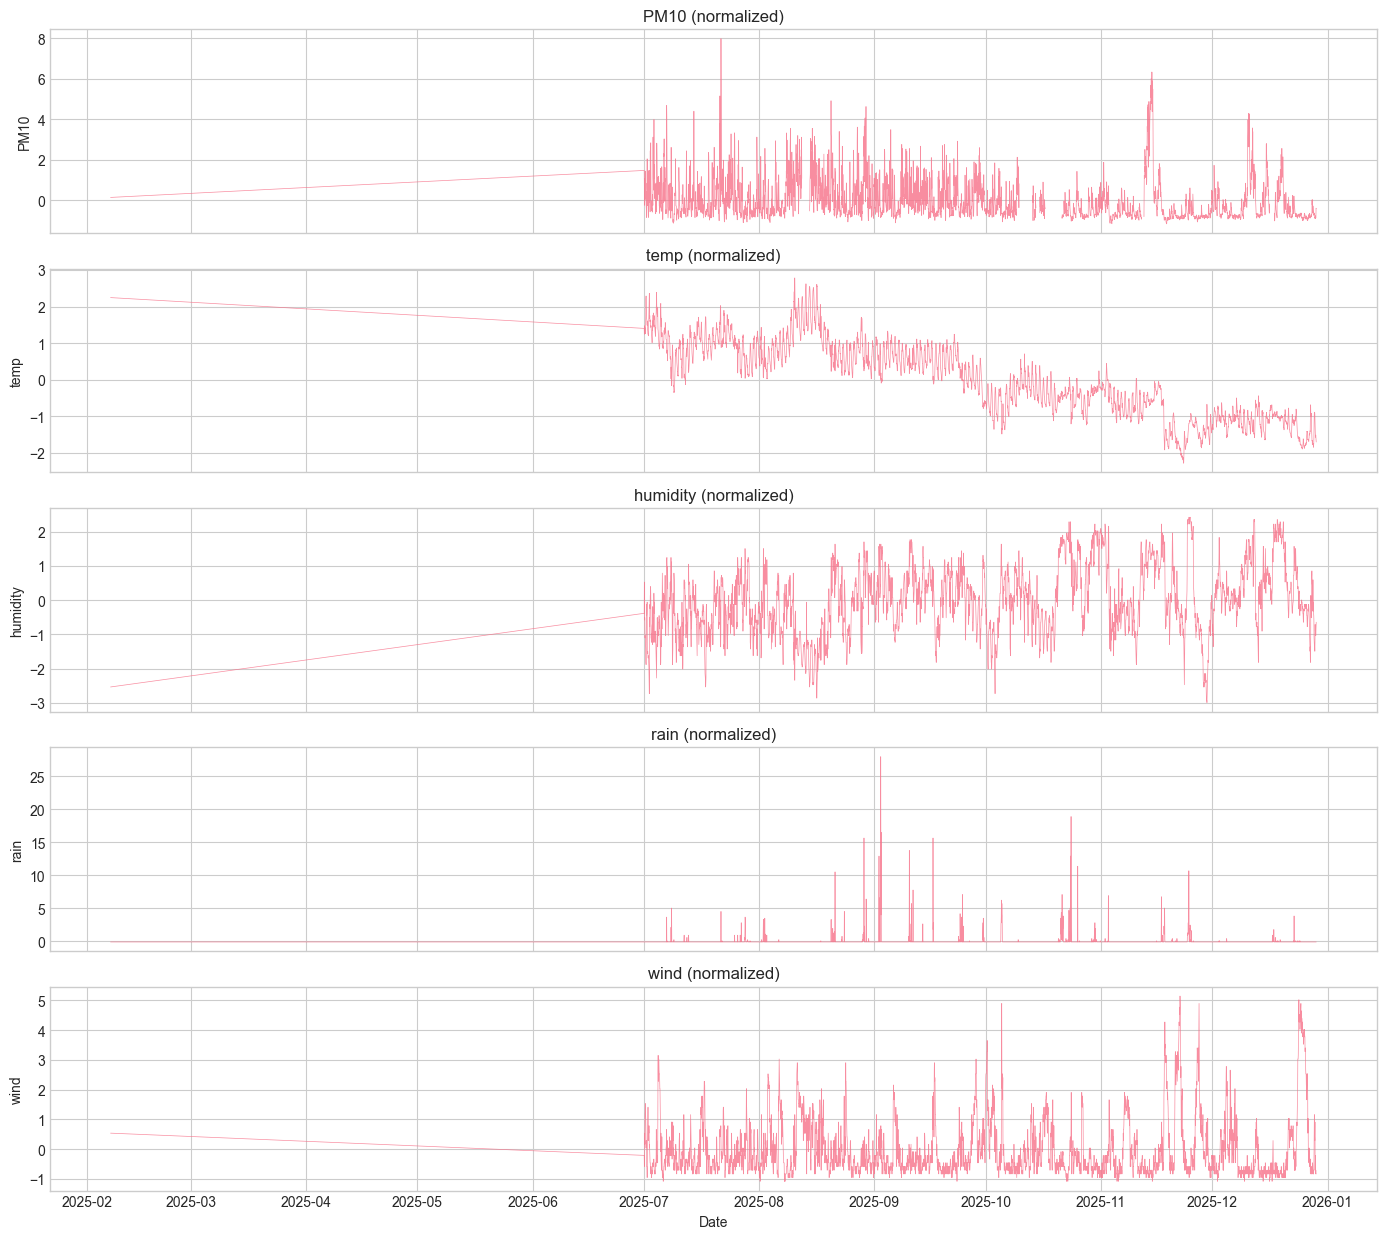

In [5]:
# Visualize raw data
fig, axes = plt.subplots(len(data_config.columns), 1, figsize=(14, 2.5 * len(data_config.columns)), sharex=True)

for i, col in enumerate(data_config.columns):
    axes[i].plot(df['datetime'], df[col], linewidth=0.5, alpha=0.8)
    axes[i].set_ylabel(col)
    axes[i].set_title(f'{col} (normalized)')
    
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

Building sequences from contiguous data blocks...

Sequence Statistics:
  Number of sequences: 8
  Min length: 24 hours
  Max length: 1355 hours
  Mean length: 503.4 hours
  Total timesteps: 4,027


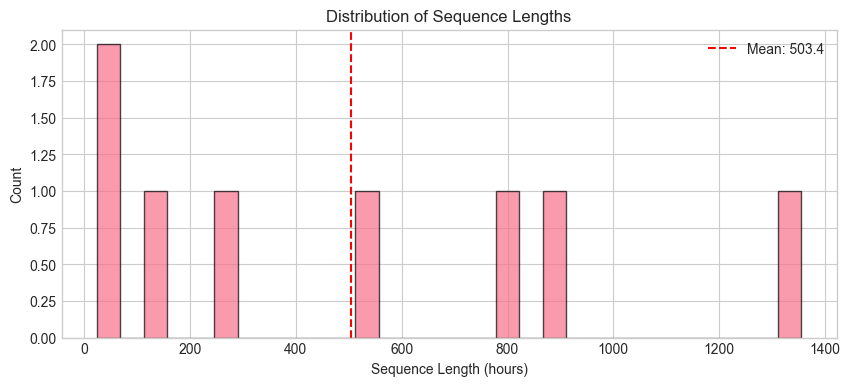

In [6]:
# Build sequences from contiguous data blocks
print("Building sequences from contiguous data blocks...")

feature_cols = list(data_config.columns)
sequences_list = build_sequences(
    df[feature_cols],
    min_length=24,  # Minimum 24 hours (1 day) per sequence
)

print(f"\nSequence Statistics:")
print(f"  Number of sequences: {len(sequences_list)}")

if len(sequences_list) > 0:
    seq_lengths = [len(s) for s in sequences_list]
    print(f"  Min length: {min(seq_lengths)} hours")
    print(f"  Max length: {max(seq_lengths)} hours")
    print(f"  Mean length: {np.mean(seq_lengths):.1f} hours")
    print(f"  Total timesteps: {sum(seq_lengths):,}")
    
    # Histogram of sequence lengths
    plt.figure(figsize=(10, 4))
    plt.hist(seq_lengths, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Sequence Length (hours)')
    plt.ylabel('Count')
    plt.title('Distribution of Sequence Lengths')
    plt.axvline(np.mean(seq_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(seq_lengths):.1f}')
    plt.legend()
    plt.show()
else:
    print("ERROR: No valid sequences found. Check data for NaN gaps.")

In [7]:
# Convert to tensors and split into train/test
sequences = sequences_to_tensors(sequences_list)

train_seqs, test_seqs = train_test_split_sequences(
    sequences,
    test_size=data_config.test_size,
    random_seed=training_config.random_seed,
)

print(f"\nTrain/Test Split:")
print(f"  Training sequences: {len(train_seqs)}")
print(f"  Test sequences: {len(test_seqs)}")
print(f"  Training timesteps: {sum(s.shape[0] for s in train_seqs):,}")
print(f"  Test timesteps: {sum(s.shape[0] for s in test_seqs):,}")


Train/Test Split:
  Training sequences: 7
  Test sequences: 1
  Training timesteps: 3,907
  Test timesteps: 120


## 3. Model Training

In [8]:
# Create model using factory
print("Creating Deep Markov Model...")
pyro.clear_param_store()  # Clear any previous parameters

model = DMMFactory.create_default(model_config)

print(f"\nModel Architecture:")
print(f"  Latent dimension (z_dim): {model_config.z_dim}")
print(f"  Transition hidden dim: {model_config.transition_dim}")
print(f"  Emission hidden dim: {model_config.emission_dim}")
print(f"  RNN hidden dim: {model_config.rnn_dim}")
print(f"  Output dimension: {model_config.output_dim}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Creating Deep Markov Model...

Model Architecture:
  Latent dimension (z_dim): 16
  Transition hidden dim: 64
  Emission hidden dim: 32
  RNN hidden dim: 64
  Output dimension: 5

  Total parameters: 22,602
  Trainable parameters: 22,602


In [9]:
# Create trainer and train the model
trainer = DMMTrainer(model, training_config)

print(f"\nTraining Configuration:")
print(f"  Learning rate: {training_config.lr}")
print(f"  Gradient clip norm: {training_config.clip_norm}")
print(f"  Number of epochs: {training_config.num_epochs}")

print(f"\n{'=' * 60}")
print("Starting Training...")
print("=" * 60)

history = trainer.fit(
    train_seqs,
    test_seqs,
    num_epochs=training_config.num_epochs,
    print_every=training_config.print_every,
)

print("\n" + "=" * 60)
print("Training Complete!")
print("=" * 60)
print(f"Final train ELBO: {history['train_losses'][-1]:.4f}")
final_test_loss = trainer.evaluate(test_seqs)
print(f"Final test ELBO: {final_test_loss:.4f}")


Training Configuration:
  Learning rate: 0.001
  Gradient clip norm: 5.0
  Number of epochs: 50

Starting Training...
Epoch 0: train ELBO = 6095.6684, test ELBO = 1511.6318
Epoch 10: train ELBO = 3549.0101, test ELBO = 1063.6992
Epoch 20: train ELBO = 2545.2602, test ELBO = 855.1516
Epoch 30: train ELBO = 2254.6548, test ELBO = 814.0885
Epoch 40: train ELBO = 1980.1299, test ELBO = 807.2235

Training Complete!
Final train ELBO: 1849.9879
Final test ELBO: 797.7201


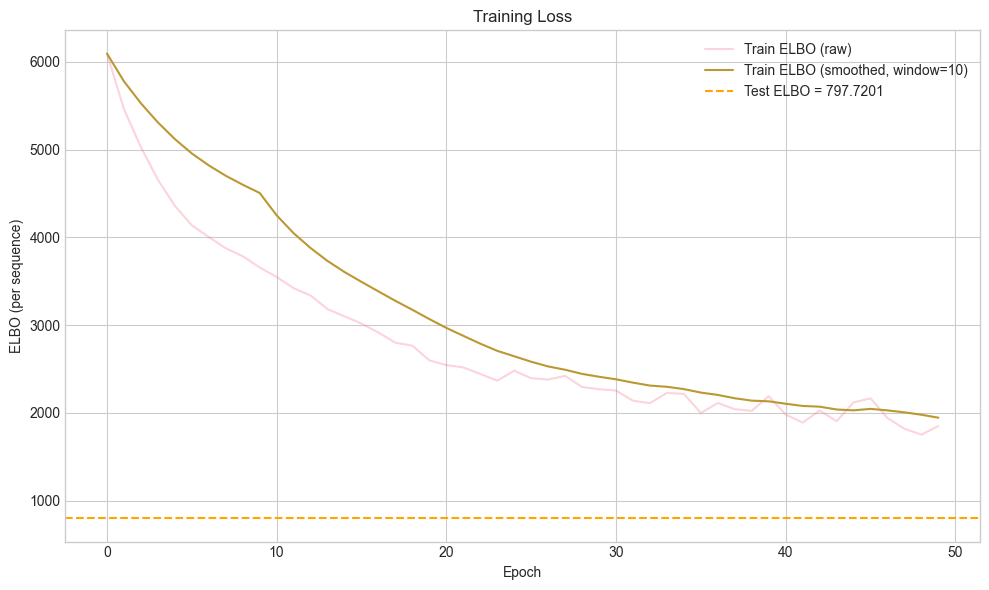

In [10]:
# Plot training loss
fig = plot_training_loss(
    history["train_losses"],
    test_loss=final_test_loss,
    smooth_window=10,
)
plt.show()

## 4. Forecasting

In [11]:
# Create forecaster
forecaster = DMMForecaster(model)

# Use the longest test sequence for inference
test_seq = max(test_seqs, key=lambda x: x.shape[0])
print(f"Using test sequence of length {test_seq.shape[0]} hours for forecasting")

Using test sequence of length 120 hours for forecasting


Inferring latent state from observed sequence...
Inferred latent state shape: torch.Size([16])


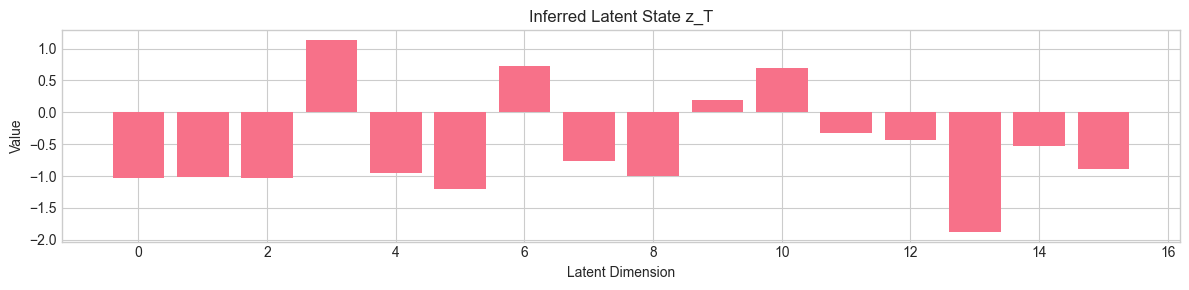

In [12]:
# Infer latent state from observations
print("Inferring latent state from observed sequence...")
z_last = forecaster.infer_latent(test_seq)
print(f"Inferred latent state shape: {z_last.shape}")

# Visualize latent state
plt.figure(figsize=(12, 3))
plt.bar(range(len(z_last)), z_last.numpy())
plt.xlabel('Latent Dimension')
plt.ylabel('Value')
plt.title('Inferred Latent State z_T')
plt.tight_layout()
plt.show()

In [13]:
# Forecast future values
FORECAST_HOURS = 168  # 7 days
NUM_SAMPLES = 100

print(f"Forecasting next {FORECAST_HOURS} hours ({FORECAST_HOURS // 24} days)...")

forecast_samples = forecaster.forecast(
    z_last,
    steps=FORECAST_HOURS,
    num_samples=NUM_SAMPLES,
)

# Get prediction intervals
mean, lower, upper = forecaster.get_prediction_intervals(
    forecast_samples,
    lower_quantile=0.1,
    upper_quantile=0.9,
)

print(f"\nForecast Results:")
print(f"  Samples shape: {forecast_samples.shape}")
print(f"  Mean forecast shape: {mean.shape}")

Forecasting next 168 hours (7 days)...

Forecast Results:
  Samples shape: torch.Size([100, 168, 5])
  Mean forecast shape: torch.Size([168, 5])


In [14]:
# Denormalize forecasts to original scale
mean_denorm = norm_stats.denormalize_all(mean.numpy(), data_config.columns)
lower_denorm = norm_stats.denormalize_all(lower.numpy(), data_config.columns)
upper_denorm = norm_stats.denormalize_all(upper.numpy(), data_config.columns)

# Print forecast summary
print("\nForecast Summary (mean values for first 24 hours, original scale):")
print("-" * 60)

for i, col in enumerate(data_config.columns):
    mean_val = mean_denorm[:24, i].mean()
    lower_val = lower_denorm[:24, i].mean()
    upper_val = upper_denorm[:24, i].mean()
    orig_mean, orig_std = norm_stats.get(col)
    print(f"  {col:10s}: {mean_val:8.2f} (90% CI: [{lower_val:.2f}, {upper_val:.2f}])")


Forecast Summary (mean values for first 24 hours, original scale):
------------------------------------------------------------
  PM10      :    10.85 (90% CI: [2.56, 19.83])
  temp      :    16.54 (90% CI: [9.40, 23.96])
  humidity  :    59.69 (90% CI: [45.13, 74.77])
  rain      :     0.00 (90% CI: [-0.05, 0.06])
  wind      :     9.77 (90% CI: [2.75, 18.00])


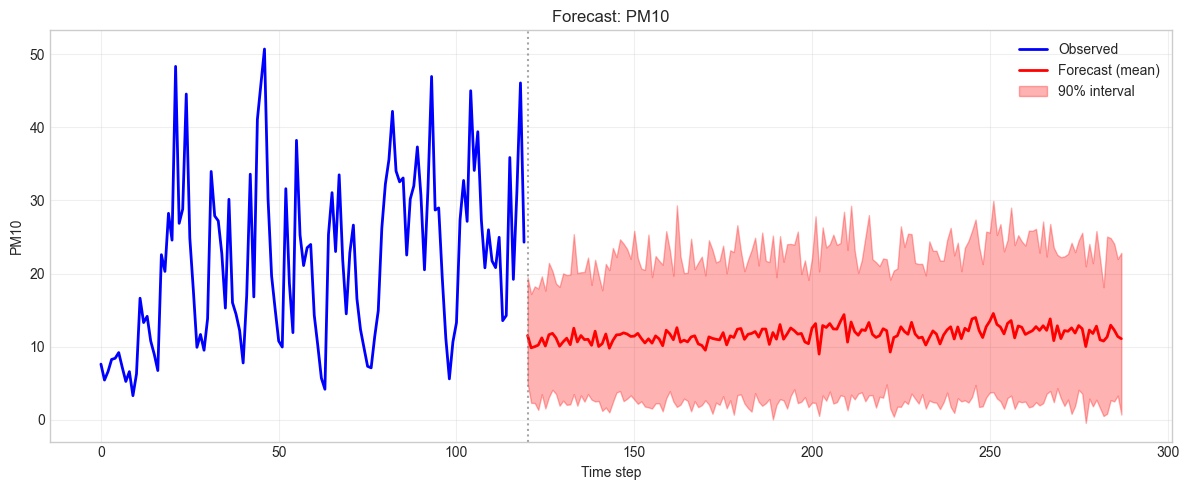

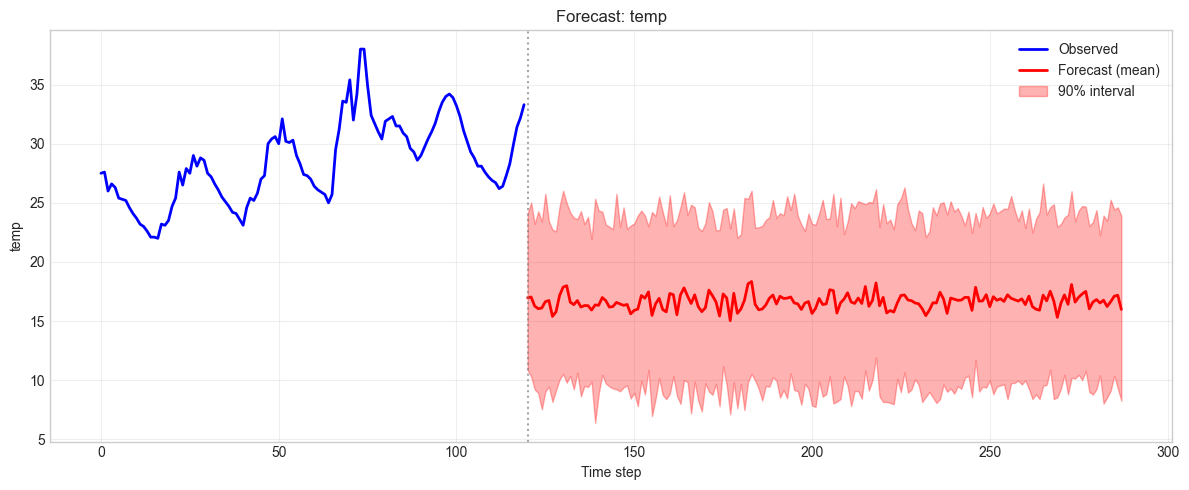

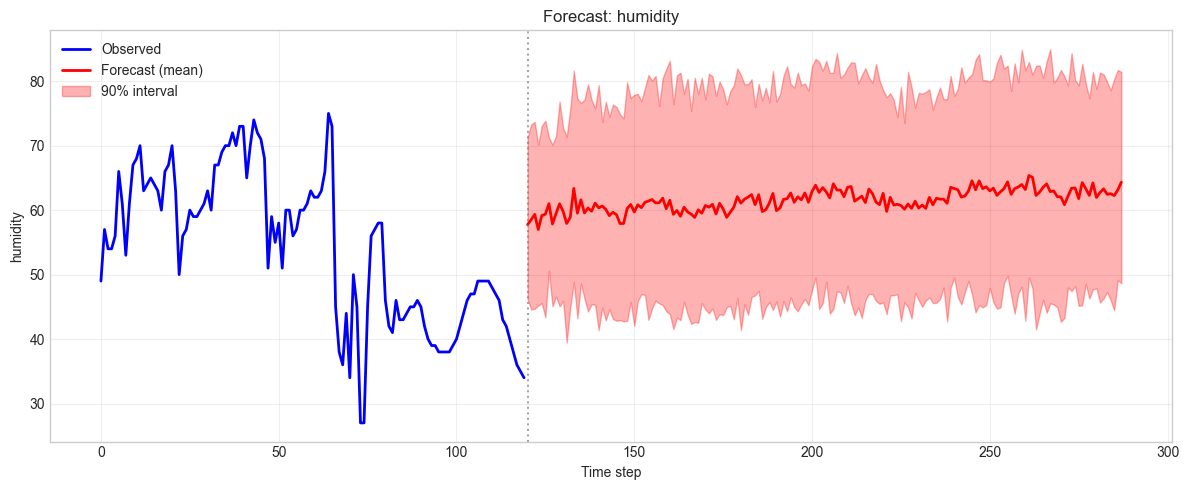

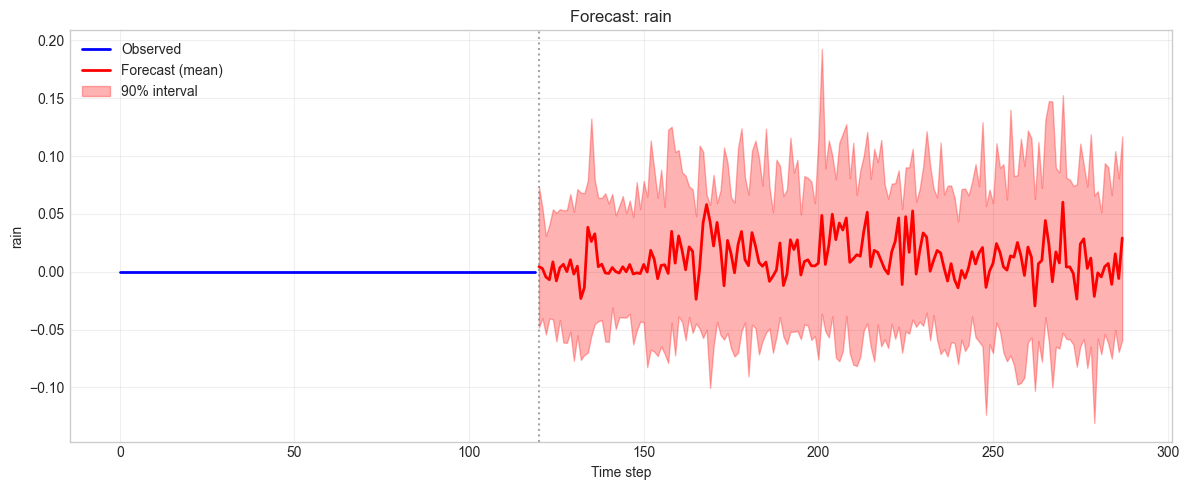

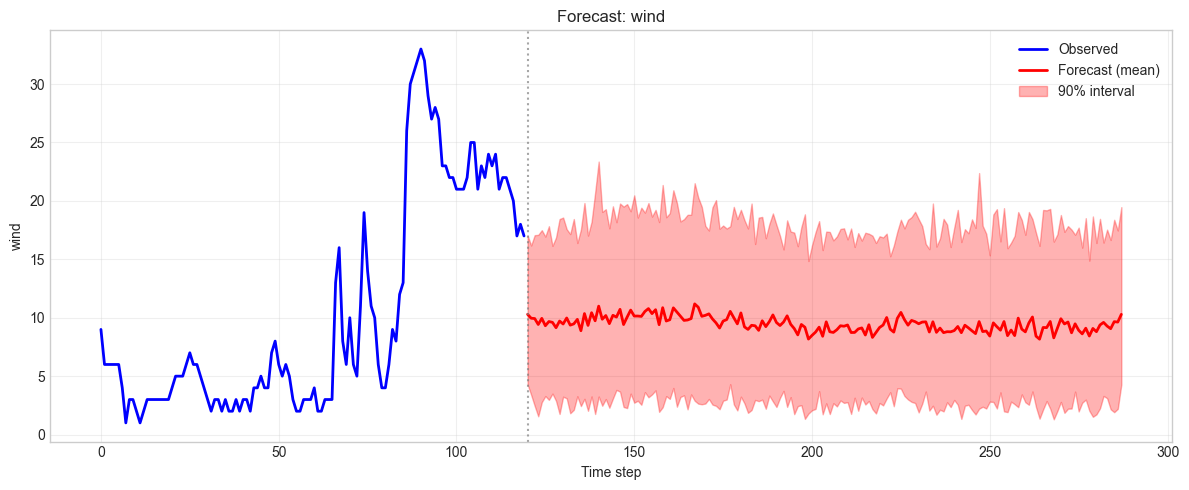

In [15]:
# Denormalize test sequence for plotting
test_seq_denorm = torch.tensor(
    norm_stats.denormalize_all(test_seq.numpy(), data_config.columns),
    dtype=torch.float32,
)
mean_denorm_t = torch.tensor(mean_denorm, dtype=torch.float32)
lower_denorm_t = torch.tensor(lower_denorm, dtype=torch.float32)
upper_denorm_t = torch.tensor(upper_denorm, dtype=torch.float32)

# Plot forecast for each feature
for i, col in enumerate(data_config.columns):
    fig = plot_forecast(
        test_seq_denorm,
        mean_denorm_t,
        lower_denorm_t,
        upper_denorm_t,
        feature_idx=i,
        feature_name=col,
    )
    plt.show()

## 5. Hidden Dynamics Analysis

In [16]:
# Create interpreter for analysis
interpreter = DMMInterpreter(model, forecaster)

# Use all sequences for analysis
all_seqs = train_seqs + test_seqs

print(f"Analyzing {len(all_seqs)} sequences...")

Analyzing 8 sequences...


In [17]:
# Comprehensive dynamics summary
print("\n" + "=" * 70)
print("COMPREHENSIVE DYNAMICS SUMMARY")
print("=" * 70)

summary = interpreter.summarize_dynamics(
    all_seqs,
    feature_names=data_config.columns,
    n_regimes=3,
)

print(f"\nAnalyzed {summary['n_sequences']} sequences ({summary['total_timesteps']:,} total timesteps)")


COMPREHENSIVE DYNAMICS SUMMARY
Analyzing hidden dynamics...
  - Detecting pollution regimes...
  - Computing feature-latent correlations...
  - Analysis complete!

Analyzed 8 sequences (4,027 total timesteps)


In [18]:
# Regime characteristics
print("\n--- Regime Characteristics ---")
print(summary["regime_characteristics"].to_string(index=False))


--- Regime Characteristics ---
 regime  count  percentage  PM10_mean  PM10_std  temp_mean  temp_std  humidity_mean  humidity_std  rain_mean  rain_std  wind_mean  wind_std
      0   1590   39.483486  -0.421496  0.597947  -0.096487  1.166134      -0.771558      0.660872  -0.133115  0.029054   0.690183  1.222822
      1   2157   53.563447   0.300393  1.098539   0.095061  0.902023       0.432894      0.799933  -0.122714  0.086438  -0.519272  0.324762
      2    280    6.953067   0.061312  1.147912  -0.151921  0.665800       1.267973      0.640402   1.766506  3.447135   0.091912  0.887578


In [19]:
# Top feature-latent correlations
print("\n--- Top Feature-Latent Correlations ---")
for feature, (dim, corr) in summary["top_correlations"].items():
    print(f"  {feature}: {dim} (r = {corr:+.3f})")


--- Top Feature-Latent Correlations ---
  PM10: z_15 (r = -0.552)
  temp: z_11 (r = -0.279)
  humidity: z_6 (r = -0.881)
  rain: z_13 (r = +0.546)
  wind: z_10 (r = -0.837)



--- Feature-Latent Correlation Heatmap ---


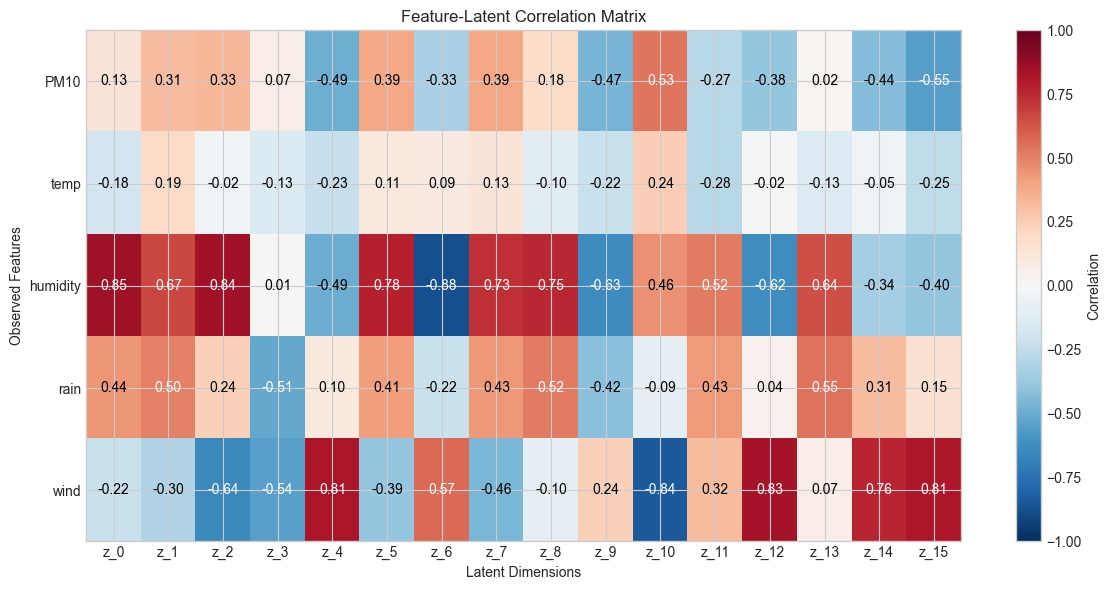

In [20]:
# Feature-latent correlation heatmap
print("\n--- Feature-Latent Correlation Heatmap ---")
fig_corr = interpreter.plot_feature_latent_correlation(all_seqs, data_config.columns)
plt.show()


--- Regime Characteristics Visualization ---


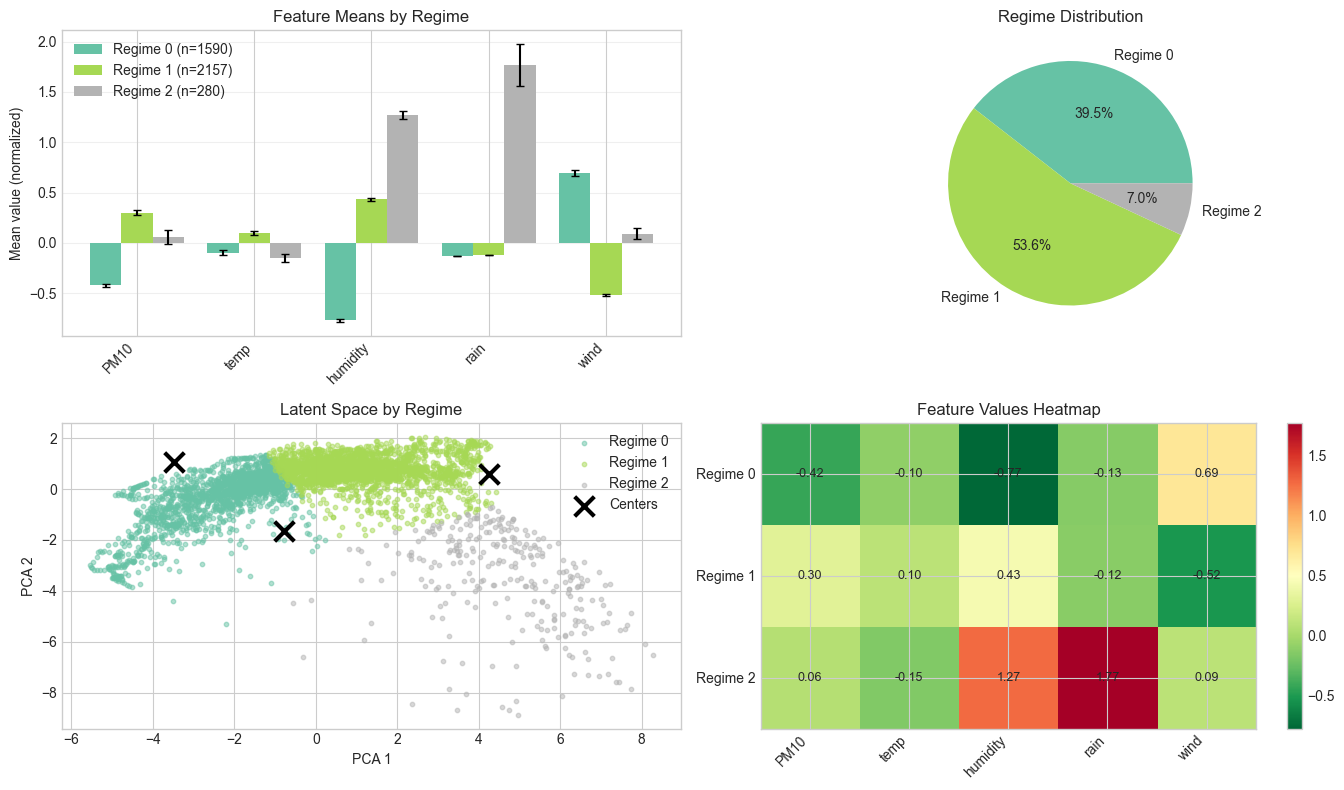

In [21]:
# Regime characteristics visualization
print("\n--- Regime Characteristics Visualization ---")
regime_result = summary["regime_result"]
fig_regimes = interpreter.plot_regime_characteristics(all_seqs, regime_result, data_config.columns)
plt.show()


--- Latent Space Trajectory ---


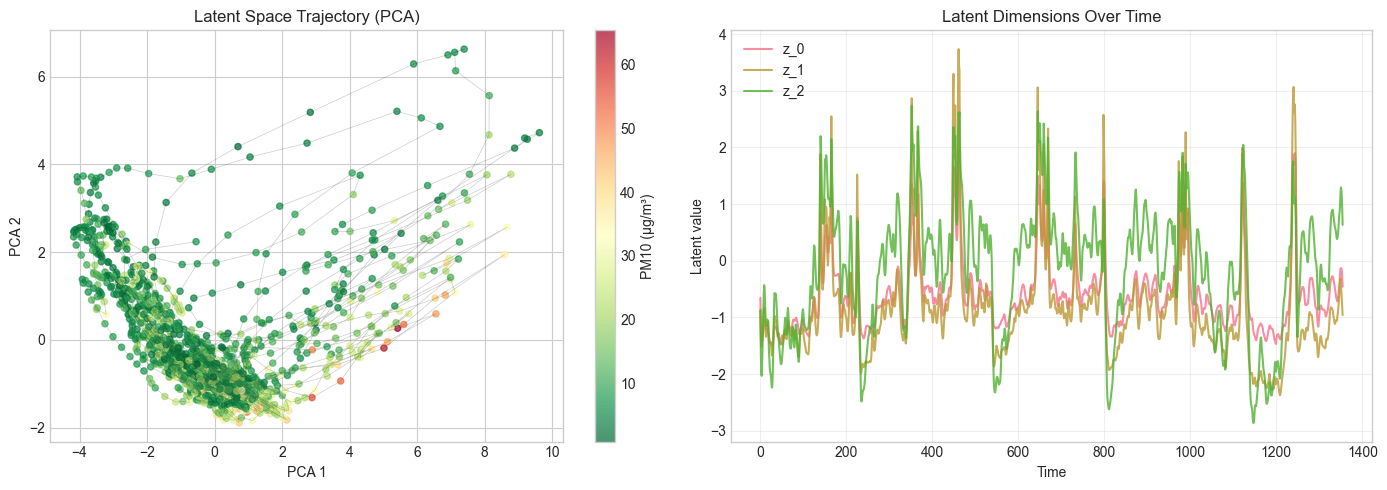

In [22]:
# Latent space trajectory
print("\n--- Latent Space Trajectory ---")

# Use longest sequence
longest_seq = max(all_seqs, key=lambda x: x.shape[0])
pm10_values = longest_seq[:, 0]  # PM10 is first column

# Denormalize PM10 for coloring
pm10_denorm = torch.tensor(
    norm_stats.denormalize(pm10_values.numpy(), "PM10"),
    dtype=torch.float32
)

fig_traj = interpreter.plot_latent_trajectory(
    longest_seq,
    method="pca",
    feature_name="PM10 (µg/m³)",
    feature_values=pm10_denorm,
)
plt.show()


--- Regime Timeline ---


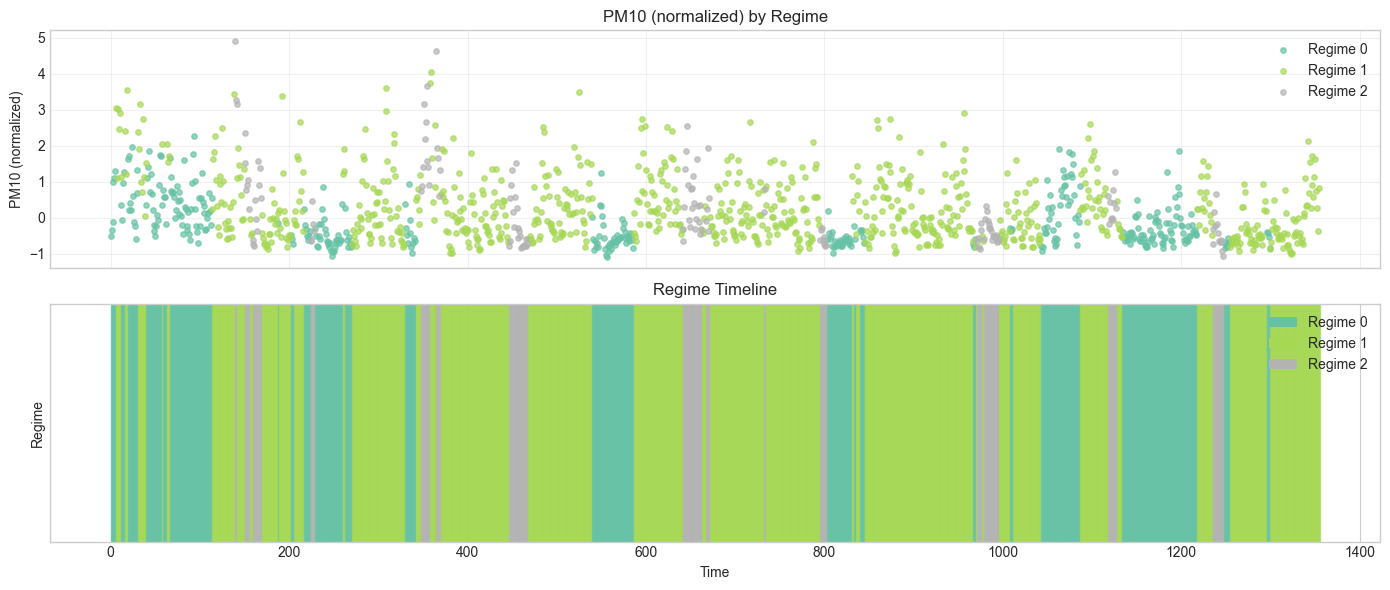

In [23]:
# Regime timeline
print("\n--- Regime Timeline ---")

# Find the index of longest_seq in all_seqs
seq_idx = 0
for i, seq in enumerate(all_seqs):
    if seq.shape[0] == longest_seq.shape[0]:
        seq_idx = i
        break

fig_timeline = interpreter.plot_regime_timeline(
    longest_seq,
    regime_result,
    seq_idx=seq_idx,
    feature_idx=0,
    feature_name="PM10 (normalized)",
)
plt.show()


--- Anomaly Detection ---
Detected 48 anomalies (threshold = 19.13)


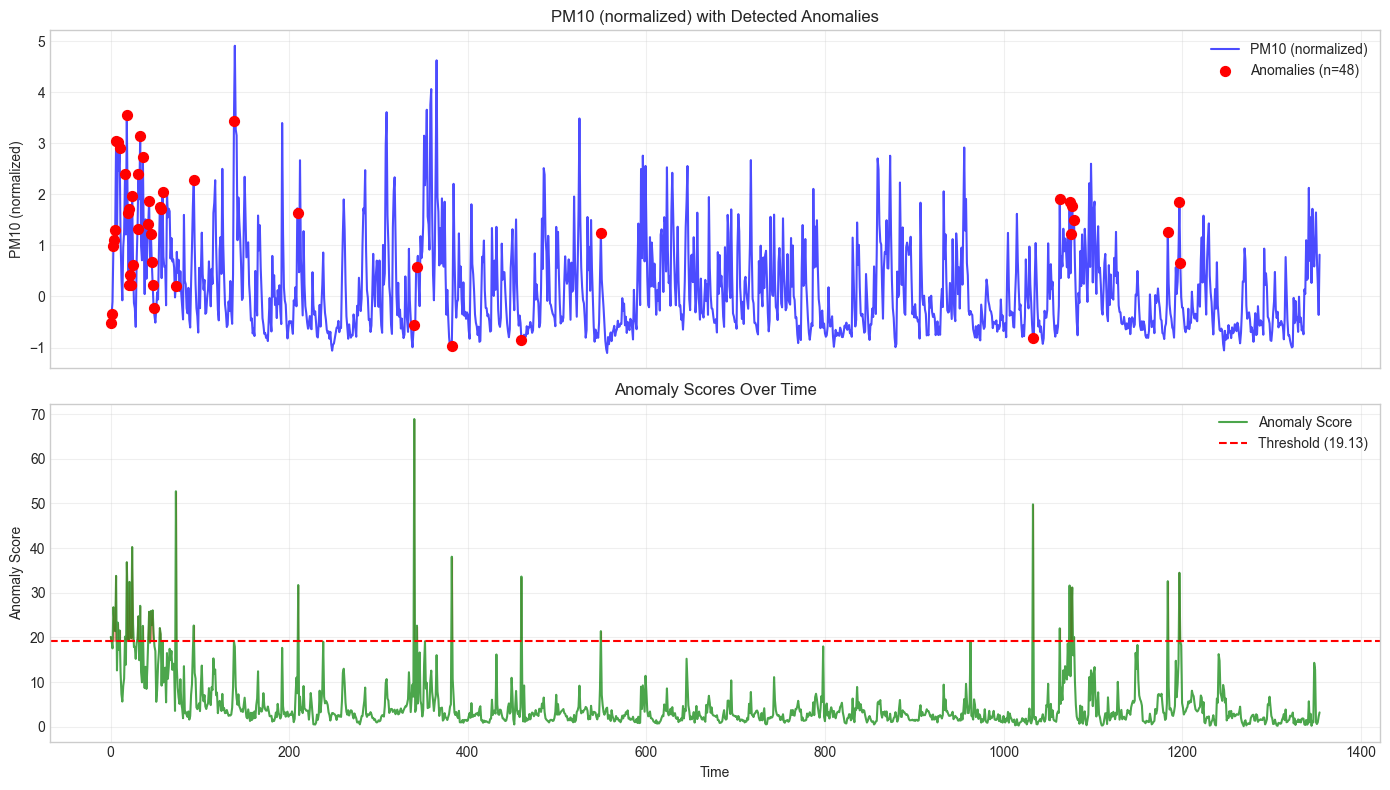

In [24]:
# Anomaly detection
print("\n--- Anomaly Detection ---")

anomaly_result = interpreter.detect_anomalies(
    longest_seq, 
    threshold=2.5, 
    method="reconstruction"
)

print(f"Detected {anomaly_result['anomalies'].sum()} anomalies (threshold = {anomaly_result['threshold']:.2f})")

fig_anomalies = interpreter.plot_anomalies(
    longest_seq,
    anomaly_result,
    feature_idx=0,
    feature_name="PM10 (normalized)",
)
plt.show()

## Interpretation Summary

In [25]:
print("=" * 70)
print("INTERPRETATION SUMMARY")
print("=" * 70)

print("\n>>> Key Findings:")

# Interpret regimes
regime_chars = summary["regime_characteristics"]
pm10_means = [regime_chars.iloc[i]["PM10_mean"] for i in range(3)]
sorted_regimes = np.argsort(pm10_means)

print("\n  Pollution Regimes (sorted by PM10 level):")
for rank, regime_idx in enumerate(sorted_regimes):
    regime = regime_chars.iloc[regime_idx]
    level = "LOW" if rank == 0 else ("HIGH" if rank == 2 else "MODERATE")
    print(f"    Regime {regime['regime']} ({level} pollution):")
    print(f"      - PM10: {regime['PM10_mean']:.2f} (normalized)")
    print(f"      - Temperature: {regime['temp_mean']:.2f}")
    print(f"      - Humidity: {regime['humidity_mean']:.2f}")
    print(f"      - Wind: {regime['wind_mean']:.2f}")
    print(f"      - Frequency: {regime['percentage']:.1f}% of time")

# Interpret correlations
print("\n  Latent Dimension Interpretations:")
for feature, (dim, corr) in summary["top_correlations"].items():
    direction = "positively" if corr > 0 else "negatively"
    print(f"    {dim} is {direction} correlated with {feature} (r={corr:+.3f})")

print("\n" + "=" * 70)
print("Analysis Complete!")
print("=" * 70)

INTERPRETATION SUMMARY

>>> Key Findings:

  Pollution Regimes (sorted by PM10 level):
    Regime 0.0 (LOW pollution):
      - PM10: -0.42 (normalized)
      - Temperature: -0.10
      - Humidity: -0.77
      - Wind: 0.69
      - Frequency: 39.5% of time
    Regime 2.0 (MODERATE pollution):
      - PM10: 0.06 (normalized)
      - Temperature: -0.15
      - Humidity: 1.27
      - Wind: 0.09
      - Frequency: 7.0% of time
    Regime 1.0 (HIGH pollution):
      - PM10: 0.30 (normalized)
      - Temperature: 0.10
      - Humidity: 0.43
      - Wind: -0.52
      - Frequency: 53.6% of time

  Latent Dimension Interpretations:
    z_15 is negatively correlated with PM10 (r=-0.552)
    z_11 is negatively correlated with temp (r=-0.279)
    z_6 is negatively correlated with humidity (r=-0.881)
    z_13 is positively correlated with rain (r=+0.546)
    z_10 is negatively correlated with wind (r=-0.837)

Analysis Complete!


## Save Results (Optional)

In [26]:
# Uncomment to save forecast results to CSV

# forecast_df = pd.DataFrame(
#     mean_denorm,
#     columns=[f"{col}_forecast" for col in data_config.columns],
# )
# forecast_df["hour"] = range(1, FORECAST_HOURS + 1)
# for i, col in enumerate(data_config.columns):
#     forecast_df[f"{col}_lower"] = lower_denorm[:, i]
#     forecast_df[f"{col}_upper"] = upper_denorm[:, i]
# 
# forecast_df.to_csv("forecast_results.csv", index=False)
# print("Saved: forecast_results.csv")

In [27]:
# Uncomment to save model checkpoint

# torch.save({
#     'model_state_dict': model.state_dict(),
#     'model_config': model_config,
#     'training_config': training_config,
#     'history': history,
# }, 'dmm_checkpoint.pt')
# print("Saved: dmm_checkpoint.pt")